In [1]:
from client_new import Client
from server import Server
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import numpy as np

In [2]:
FILE_NUM = int(1e3)
REQUEST_NUM = int(5e2)
client = Client(FILE_NUM, REQUEST_NUM)

print('FILE_NUM', FILE_NUM)
print('REQUEST_NUM', REQUEST_NUM)
print('client.file_pool_size', client.file_pool_size)
# pd.DataFrame(client.trace).to_csv('trace_normal.csv')  # 'trace_' + str(np.random.randint(1000)) + '.csv'
# pd.DataFrame(client.trace_with_attack).to_csv('trace_attack.csv')

total_client_requests: 59520
FILE_NUM 1000
REQUEST_NUM 500
client.file_pool_size 1014919


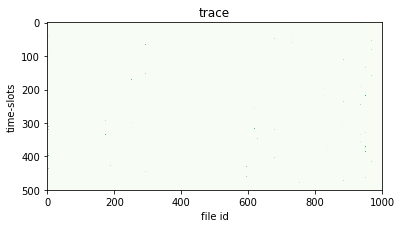

In [3]:
# fig = plt.figure(figsize=(15, 3))  # LRU
# fig = plt.figure(figsize=(3, 15))  # LFU
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(client.trace, cmap='Greens')
plt.ylabel("time-slots")
plt.xlabel("file id")
plt.title("trace")
plt.show()

In [4]:
server_hit_rate, server_hit_rate_with_attack = [], []
cache_size_array = []
print('\n' + '#' * 80 + '\n')

hit_rate_stable_for_all = {}


def attack(attack_level):
    client.__make_attack_trace__(client.total_attack_requests // client.num_of_time_stamps, attack_level)
    client.total_attack_requests = np.sum(np.sum(client.attack_trace))
    print('total_attack_requests:', client.total_attack_requests)

    # fig = plt.figure(figsize=(15, 3))  # LRU
    # fig = plt.figure(figsize=(3, 15))  # LFU
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(client.attack_trace, cmap='Reds')
    plt.ylabel("time-slots")
    plt.xlabel("file id")
    plt.title("attack-trace" + attack_level)
    plt.show()

    # for cache_size in range(client.file_pool_size // 100, client.file_pool_size // 2, client.file_pool_size // 500):
    for cache_size in [1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5]:
        cache_size_array.append(cache_size)
        print('cache_size', cache_size)
        # two identical servers
        server = Server(cache_size, 'LRU')
        server_under_attack = deepcopy(server)

        hit_rate_stable = []  # record hit_rate after each file request
        # just normal trace
        for request_file in client.make_requests(client.trace):
            server.handle(request_file)
            hit_rate_stable.append(server.hit_rate())  # record hit_rate after each file request

        if cache_size not in hit_rate_stable_for_all:
            hit_rate_stable_for_all[cache_size] = {}
        hit_rate_stable_for_all[cache_size][attack_level] = hit_rate_stable

        server_hit_rate.append(server.hit_rate())

        # normal trace with attack trace
        trace = client.trace + client.attack_trace
        # print(1000 == len(trace), np.sum(np.sum(client.trace_with_attack)))
        print('normal:', server_hit_rate[-1])

        for request_file in client.make_requests(trace):
            server_under_attack.handle(request_file)
        server_hit_rate_with_attack.append(server_under_attack.hit_rate())
        print('attack:', server_hit_rate_with_attack[-1])


################################################################################



max_num_requests_for_single_time_stamp: 2.0
total_attack_requests: 51


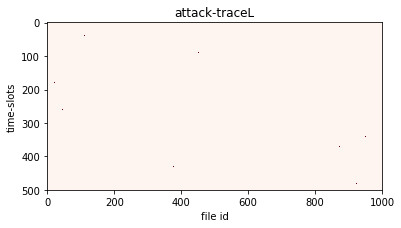

cache_size 1000.0
normal: 0.23282929716348627
attack: 0.22898725505720477
cache_size 2000.0
normal: 0.3980678696561178
attack: 0.3983481828683725
cache_size 5000.0
normal: 0.6180779466048733
attack: 0.619445693047864
cache_size 10000.0
normal: 0.7674731053851965
attack: 0.7650702394609754
cache_size 20000.0
normal: 0.8428091256248468
attack: 0.8424400993362526
cache_size 50000.0
normal: 0.888928076462902
attack: 0.8879823926410101
cache_size 100000.0
normal: 0.9272177263572291
attack: 0.9264071288645964
max_num_requests_for_single_time_stamp: 2.0
total_attack_requests: 7


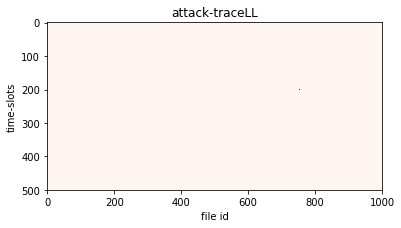

cache_size 1000.0
normal: 0.22963709291604348
attack: 0.2320627575375417
cache_size 2000.0
normal: 0.39627015463255794
attack: 0.3956019890872715
cache_size 5000.0
normal: 0.6180275433799136
attack: 0.6189964113932096
cache_size 10000.0
normal: 0.7656753903616367
attack: 0.7690963635140968
cache_size 20000.0
normal: 0.8429603352997256
attack: 0.8432643868620225
cache_size 50000.0
normal: 0.8889616786128751
attack: 0.8882523747500736
cache_size 100000.0
normal: 0.9275369467819734
attack: 0.9276798607744409
max_num_requests_for_single_time_stamp: 24.0
total_attack_requests: 5937


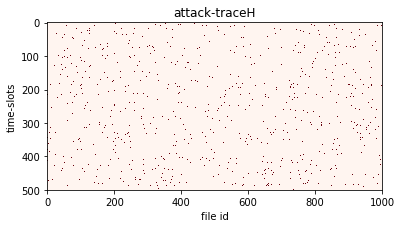

cache_size 1000.0
normal: 0.23212365201405155
attack: 0.19499824014241043
cache_size 2000.0
normal: 0.39657257398231566
attack: 0.3363276603521753
cache_size 5000.0
normal: 0.6179939412299406
attack: 0.5375589999914601
cache_size 10000.0
normal: 0.7668346645357079
attack: 0.6739386058948836
cache_size 20000.0
normal: 0.8432459535744968
attack: 0.7490871755643067
cache_size 50000.0
normal: 0.8890792861377809
attack: 0.7973631422557841
cache_size 100000.0
normal: 0.9273017317321618
attack: 0.8291855595400712
max_num_requests_for_single_time_stamp: 2.0
total_attack_requests: 513


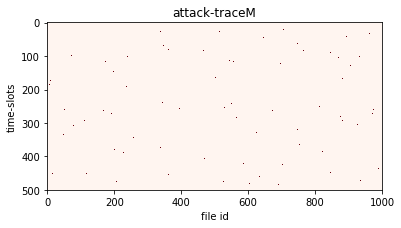

cache_size 1000.0
normal: 0.2316868240644015
attack: 0.22757483005055837
cache_size 2000.0
normal: 0.3990759341553103
attack: 0.39140138937915164
cache_size 5000.0
normal: 0.6168178659808826
attack: 0.6095147567252219
cache_size 10000.0
normal: 0.7668514656106945
attack: 0.7592490670256515
cache_size 20000.0
normal: 0.8436659804491603
attack: 0.8346909060901354
cache_size 50000.0
normal: 0.8891128882877539
attack: 0.8796161964316926
cache_size 100000.0
normal: 0.9275201457069868
attack: 0.9175619922782138


In [5]:
for attack_level in {'H', 'M', 'L', 'LL'}:
    attack(attack_level)

<IPython.core.display.Javascript object>


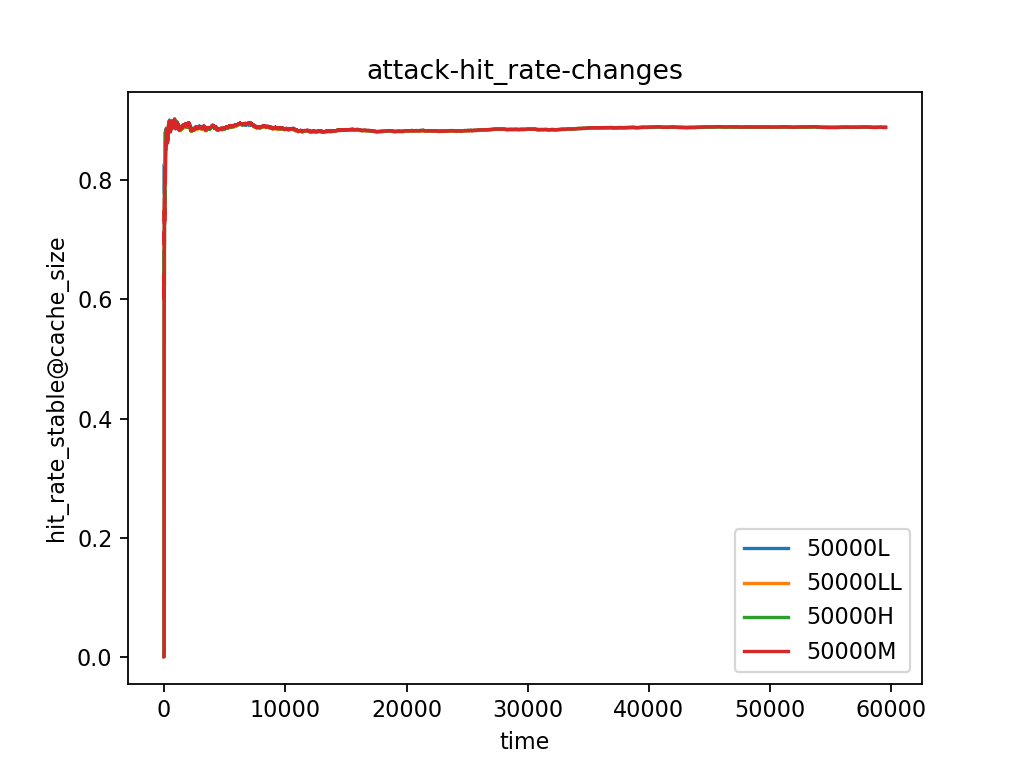

In [9]:
%matplotlib notebook
plt.figure()  # figsize=(15, 10)
# for cache_size in hit_rate_stable_for_all:
cache_size=50000
for attack_level in hit_rate_stable_for_all[cache_size]:
    tmp = hit_rate_stable_for_all[cache_size][attack_level]
    lb = str(cache_size) + attack_level
    plt.plot(range(len(tmp)), tmp, label=lb)
plt.ylabel("hit_rate_stable@cache_size")
plt.xlabel("time")
plt.title("attack-hit_rate-changes")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


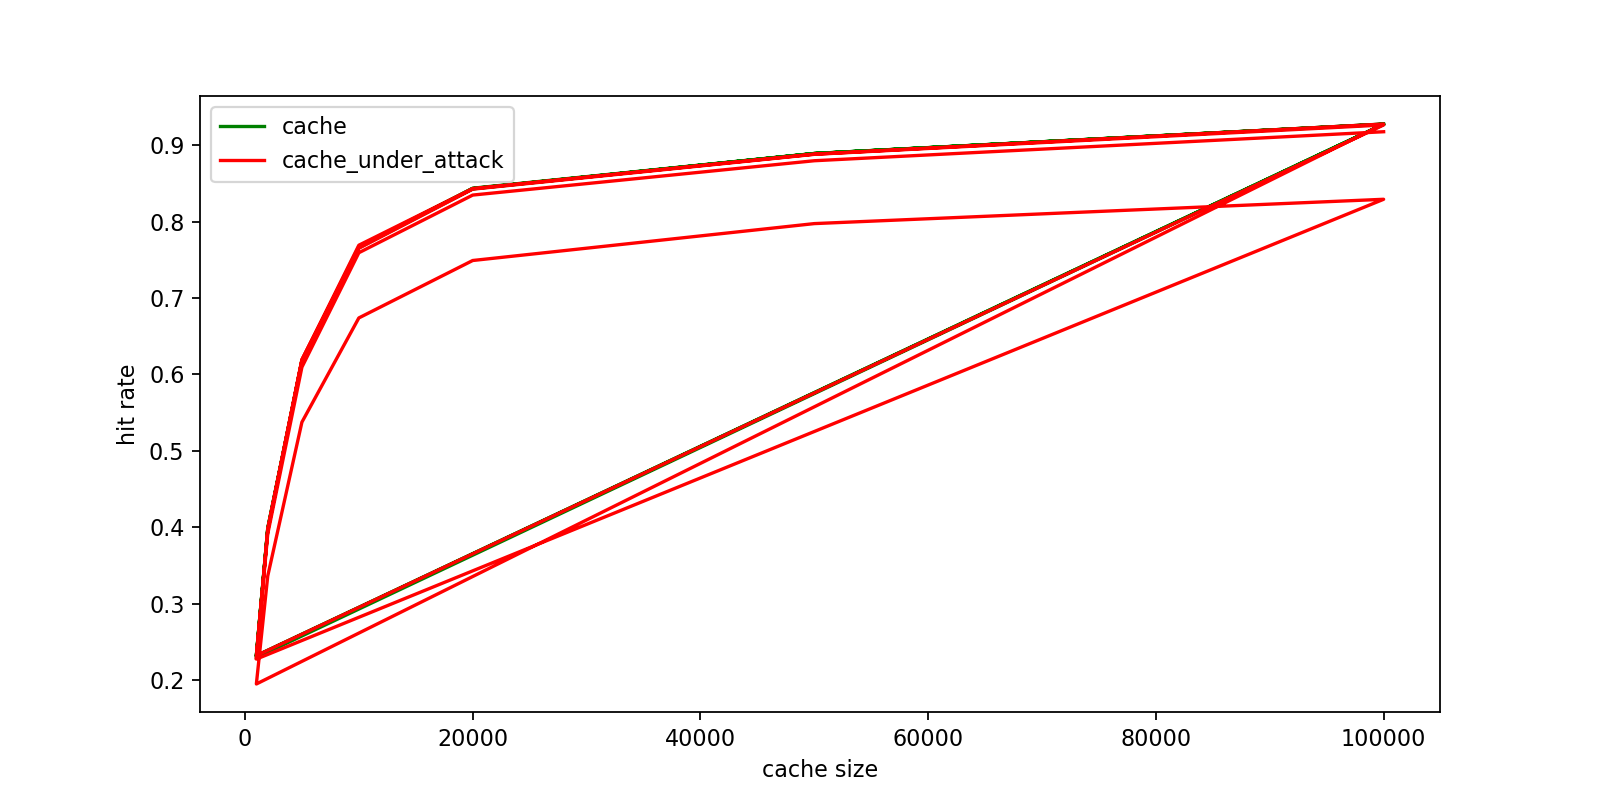

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(cache_size_array, server_hit_rate, color='green', label='cache')
plt.plot(cache_size_array, server_hit_rate_with_attack, color='red', label='cache_under_attack')
plt.xlabel("cache size")
plt.ylabel("hit rate")
plt.legend()
plt.show()